# END-TO-END IMPACT CALCULATION

The goal of this tutorial is to show a full end-to-end impact computation using as example __[Tropical Cyclones](climada_hazard_TropCyclone.ipynb)__. For details about how to define __[Exposures](climada_entity_Exposures.ipynb)__ , __[Hazard](climada_hazard_Hazard.ipynb)__, __[Impact Functions](climada_entity_ImpactFuncSet.ipynb)__ and __[Discount Rates](climada_entity_DiscRates.ipynb)__, see the respective tutorials. Note that this tutorial examplifies the work flow, but does not explore all possible features.

The steps of an impact caculations are typically:

- Set exposure
- Set hazard and hazard centroids matching
- Set impact functions in impact function set
- Compute impact
- Visualize, save, use impact output



Before computing the impact of a given exposure and hazard, it is important to correctly match the exposures' coordinates with the hazard centroids. Try to have similar resolutions in exposures and hazard. By the impact calculation the nearest neighbor for each exposure to the hazard's centroids is searched. 

Hint: set first the `Exposures` and use its coordinates information to set a matching `Hazard`.

## Detailed Impact calculation - LitPop + TropCyclone

We begin with one very detailled example, and later present in quick and dirty examples.

### Define the exposure

Reminder: The exposures must be defined according to your problem either using CLIMADA exposures such as __[BlackMarble](climada_entity_BlackMarble.ipynb)__, __[LitPop](climada_entity_LitPop.ipynb), [OSM](climada_entity_openstreetmap.ipynb)__, extracted from external sources (imported via csv, excel, api, ...) or directly user defined. As a reminder, exposures  as geopandas dataframes with at least columns define the latitude, longitude and value of exposures. In addition, for impact calculations, for each exposure value the corresponding impact function to use (defined by the column if_) and the centroids must be defined.

Exposures are typically either defined as a series of (latitude/longitude) points or as a raster of (latitude/longitude) points. Fundamentally, this changes nothing for the impact computations. But, when setting the centroids to be used with the hazard, note that either the point or raster method should then be used (c.f. __[Hazard](climada_hazard_Hazard.ipynb)__). Moreover, note that for larger number of points, consider using a raster which might be more efficient (computationally). For a low number of points, avoid using a raster if this adds a lot of exposures values equal to 0. 

We shall here use a raster example.

In [92]:
#Exposure from the module Litpop 
#Note that the file gpw_v4_population_count_rev11_2015_30_sec.tif must first be downloaded (do not forget to unzip)

%matplotlib inline
import numpy as np
from climada.entity import LitPop

# Cuba with resolution 10km and financial_mode = income group.
exp_lp = LitPop()
exp_lp.set_country(countries=['CUB'], res_km=10, fin_mode='income_group')
exp_lp.reset_index() #Why? #What is the coordinate system used?
exp_lp.check()

2020-10-16 18:45:14,788 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 300.0 arcsec.
2020-10-16 18:45:17,412 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2020-10-16 18:45:17,412 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2020-10-16 18:45:33,286 - climada.util.finance - INFO - GDP CUB 2016: 9.137e+10.
2020-10-16 18:45:33,424 - climada.util.finance - INFO - Income group CUB 2016: 3.
2020-10-16 18:45:33,587 - climada.entity.exposures.litpop - INFO - Creating the LitPop exposure took 19 s
2020-10-16 18:45:33,588 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-10-16 18:45:33,588 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-16 18:45:33,589 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-16 18:45:33,589 - climada.entity.exposures.base - INFO - cover not set.
2020-10-16 18:45:33,590 - cli

2020-10-16 18:45:33,612 - climada.util.coordinates - INFO - Raster from resolution 0.0833333333333286 to 0.0833333333333286.

 Raster properties exposures: {'width': 163, 'height': 138, 'crs': {'init': 'epsg:4326', 'no_defs': True}, 'transform': Affine(0.0833333333333286, 0.0, -73.41666666666669,
       0.0, -0.0833333333333286, 12.166666666666664)}


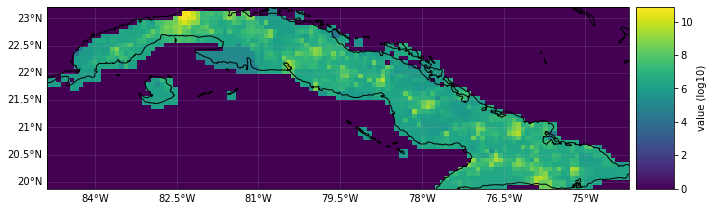

In [93]:
# not needed for impact calculations
# visualize the define exposure
exp_lp.plot_raster()
print('\n Raster properties exposures:', exp_ras.meta)

### Define the hazard 

Let us define a tropical cyclone hazard using the TropCyclone and TCTracks modules. 

In [94]:
from climada.hazard import TCTracks, TropCyclone, Centroids

# Load histrocial tropical cyclone tracks from ibtracs over the North Atlantic basin between 2010-2012
ibtracks_na = TCTracks()
ibtracks_na.read_ibtracs_netcdf(provider='usa', basin='NA', year_range=(2010, 2012), correct_pres=True)
print('num tracks hist:', ibtracks_na.size)
#Add randomly generated tracks using the calc_random_walk method (2 per historical track)
ibtracks_na.calc_random_walk(ens_size=2)
print('num tracks hist+syn:', ibtracks_na.size)
ibtracks_na.equal_timestep(0.5)  # why needed?

2020-10-16 18:45:34,876 - climada.hazard.tc_tracks - WARNING - `correct_pres` is deprecated. Use `estimate_missing` instead.
2020-10-16 18:45:35,400 - climada.hazard.tc_tracks - INFO - Progress: 10%
2020-10-16 18:45:35,516 - climada.hazard.tc_tracks - INFO - Progress: 20%
2020-10-16 18:45:35,624 - climada.hazard.tc_tracks - INFO - Progress: 30%
2020-10-16 18:45:35,730 - climada.hazard.tc_tracks - INFO - Progress: 40%
2020-10-16 18:45:35,839 - climada.hazard.tc_tracks - INFO - Progress: 50%
2020-10-16 18:45:35,947 - climada.hazard.tc_tracks - INFO - Progress: 60%
2020-10-16 18:45:36,056 - climada.hazard.tc_tracks - INFO - Progress: 70%
2020-10-16 18:45:36,162 - climada.hazard.tc_tracks - INFO - Progress: 80%
2020-10-16 18:45:36,272 - climada.hazard.tc_tracks - INFO - Progress: 90%
num tracks hist: 60
2020-10-16 18:45:36,412 - climada.hazard.tc_tracks_synth - INFO - Computing 120 synthetic tracks.
num tracks hist+syn: 180
2020-10-16 18:45:42,730 - climada.hazard.tc_tracks - INFO - Interp

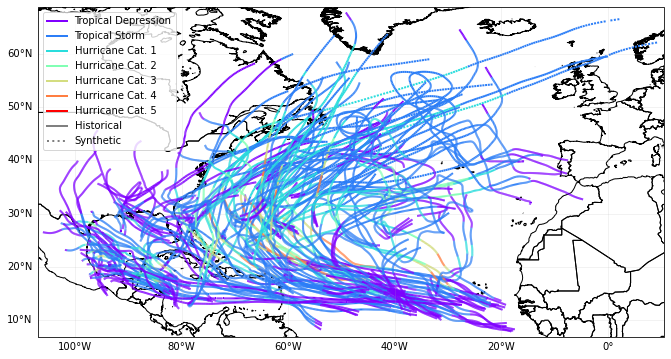

In [95]:
# not needed for calculations
# visualize tracks
ax = ibtracks_na.plot()
ax.get_legend()._loc = 2

From the tracks, we generate the hazards (the tracks are only the coordinates of the center of the cyclones, the full cyclones however affects a region around the tracks). 

First thing we define the set of centroids which are geographical points where the hazard has a defined value. In our case, we want to define windspeeds from the tracks.

Remember:
In the impact computations, for each exposure geographical point, one must assign a centroid from the hazard. By default, each exposure is assigned to the closest centroid from the hazard. But one can also define manually which centroid is assigned to which exposure point.

Examples: 
- Define the exposures from a given source (e.g., raster of asset values from LitPop). Define the hazard centroids from the exposures' geolocations (e.g. compute tropical storm windspeed at each raster point and assign centroid to each raster point).
- Define the exposures from a given source (e.g. houses position and value). Define the hazard from a given source (e.g. where lanslides occur). Use a metric to assign to each exposures point a hazard centroid (all houses in a radius of 5km around the lanslide are assigned to this centroid, if a house is within 5km of two landslides, choose the closest one). 
- Define a geographical raster. Define the exposures value on this raster. Define the hazard centroids on the geographical raster.

We shall pursue with the first case (Litpop + TropicalCyclone)

Hint: computing the wind speeds in many locations for many tc tracks is a computationally costly operation. Thus, we should define centroids only where we also have an exposure.

In [96]:
# Define the centroids from the exposures position
centrs = Centroids()
lat = exp_lp['latitude'].values
lon = exp_lp['longitude'].values
centrs.set_lat_lon(lat, lon)
centrs.check()

In [97]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone()
tc.set_from_tracks(ibtracks_na, centrs)
tc.check()

2020-10-16 18:46:15,232 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.
2020-10-16 18:46:15,660 - climada.util.coordinates - INFO - dist_to_coast: UTM 32616 (1/3)
2020-10-16 18:46:15,972 - climada.util.coordinates - INFO - dist_to_coast: UTM 32617 (2/3)
2020-10-16 18:46:16,651 - climada.util.coordinates - INFO - dist_to_coast: UTM 32618 (3/3)
2020-10-16 18:46:17,104 - climada.hazard.trop_cyclone - INFO - Mapping 180 tracks to 1387 centroids.
2020-10-16 18:46:18,098 - climada.hazard.trop_cyclone - INFO - Progress: 10%
2020-10-16 18:46:18,728 - climada.hazard.trop_cyclone - INFO - Progress: 20%
2020-10-16 18:46:19,847 - climada.hazard.trop_cyclone - INFO - Progress: 30%
2020-10-16 18:46:21,072 - climada.hazard.trop_cyclone - INFO - Progress: 40%
2020-10-16 18:46:22,196 - climada.hazard.trop_cyclone - INFO - Progress: 50%
2020-10-16 18:46:22,800 - climada.hazard.trop_cyclone - INFO - Progress: 60%
2020-10-16 18:46:23,599 - climada.hazard.trop_cycl

Hint: The operation of computing the windspeed in different location is in general computationally expensive. Hence, if you have a lot of tropical cyclone tracks, you should first make sure that all your tropical cyclones actually affect your exposure (remove those that don't). Then, be careful when defining the centroids. For a large country like  China, there is no need for centroids 500km inlans (no tropical cyclones gets so far).

### Impact function 

For Tropical Cyclones, some calibrated default impact functions exist. Here we will use the one from Emanuel (2011).

In [99]:
from climada.entity import ImpactFuncSet, IFTropCyclone
# impact function TC
impf_tc= IFTropCyclone()
impf_tc.set_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)

Recall that the exposure - hazard - impact functions must be matched in the impact calculations. Here it is simple, since there is a single impact function for all the hazards. We now must simply make sure that the exposure is assigned this impact function through renaming the `if_` column from the hazard type of the impact function in the impact function set and set the values of the column to the id of the impact function. 

In [100]:
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [101]:
# rename column and assign id
exp_lp.rename(columns={"if_": "if_" + haz_type}, inplace=True)
exp_lp['if_' + haz_type] = haz_id
exp_lp.head()

,value,latitude,longitude,region_id,if_TC
0,9.818338e+05,21.875000,-84.875000,192,1
1,1.110009e+06,21.875000,-84.791667,192,1
2,0.000000e+00,21.958333,-84.708333,192,1
3,1.026952e+06,21.958333,-84.625000,192,1
4,1.109359e+06,21.958333,-84.541667,192,1


### Impact computation 

We are finally ready for the impact computation. This is the simplest step. Just give the exposure, impact function and hazard to the Impact.calc() method.

Note: we did not specifically assign centroids to the exposures. Hence, the default is used - each exposure is associated with the closest centroids. Since we defined the centroids from the exposures, this is a one-to-one mapping.

In [104]:
# Compute impact
imp = Impact()
imp.calc(exp_lp, impf_set, tc, save_mat=False) #Do not safe all the results

2020-10-16 18:48:11,468 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-10-16 18:48:11,470 - climada.engine.impact - INFO - Calculating damage for 1373 assets (>0) and 180 events.


For example we can now obtain the aggregated average annual impact or plot the average annual impact in each exposure location.

In [108]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 250864488.0 $


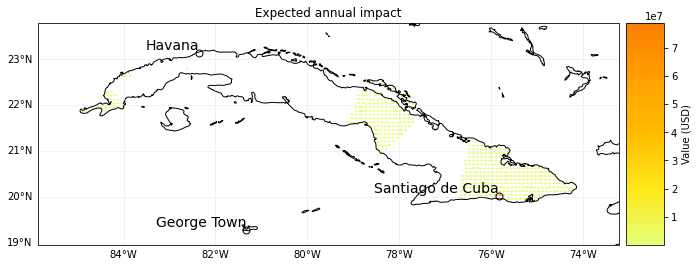

In [114]:
imp.plot_hexbin_eai_exposure(buffer=1)

## Quick examples - points, raster, custom

# VISUALIZATION

The expected annual impact per exposure can be visualized through different methods: `plot_hexbin_eai_exposure()`, `plot_scatter_eai_exposur()`, `plot_raster_eai_exposure()` and `plot_basemap_eai_exposure()` (similarly as with  `Exposures`).

2020-10-16 11:22:36,585 - climada.util.coordinates - INFO - Setting geometry points.
2020-10-16 11:22:36,686 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/opt/anaconda3/envs/climada_env2/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ckropf/opt/anaconda3/envs/climada_env2/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/ckropf/opt/anaconda3/envs/climada_env2/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/ckropf/opt/anacond

2020-10-16 11:22:38,961 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/opt/anaconda3/envs/climada_env2/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


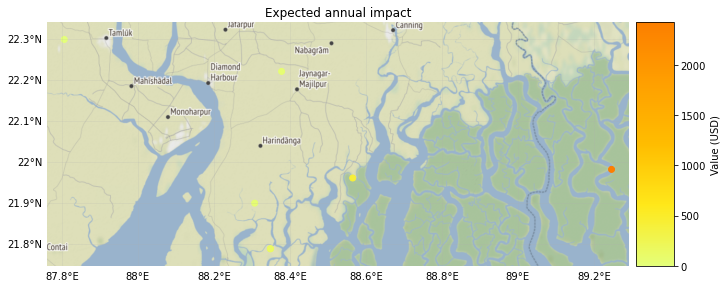

In [4]:
imp_pnt.plot_basemap_eai_exposure(buffer=5000)

## Making videos

Given a fixed exposure and impact functions, a sequnce of hazards can be visualized hitting the exposures.

2019-10-29 18:17:55,127 - climada.util.finance - INFO - GDP USA 2016: 1.871e+13.
2019-10-29 18:17:55,180 - climada.util.finance - INFO - Income group USA 2016: 4.
2019-10-29 18:17:55,180 - climada.entity.exposures.black_marble - INFO - Nightlights from NASA's earth observatory for year 2016.
2019-10-29 18:17:55,796 - climada.entity.exposures.nightlight - DEBUG - Found all required satellite data (4 files) in folder /Users/aznarsig/Documents/Python/climada_python/data/system
2019-10-29 18:17:55,797 - climada.entity.exposures.nightlight - DEBUG - All required files already exist. No downloads necessary.
2019-10-29 18:21:45,895 - climada.entity.exposures.black_marble - INFO - Processing country United States Of America.
2019-10-29 18:29:41,450 - climada.entity.exposures.black_marble - INFO - Generating resolution of approx 2.5 km.
2019-10-29 18:29:42,812 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2019-10-29 18:29:42,815 - climada.entity.exposures.base - INFO - cen

23it [07:27, 28.51s/it]                        


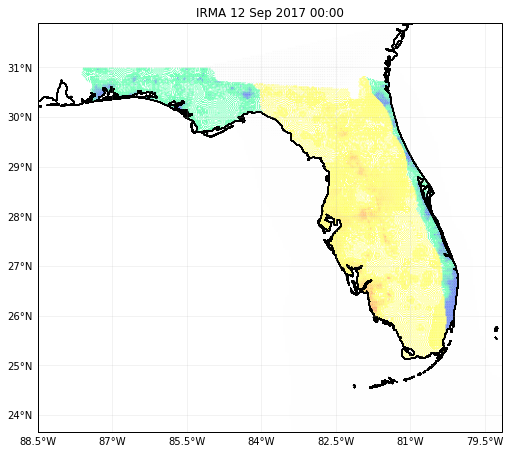

In [4]:
# exposure
from climada.entity import BlackMarble, add_sea
country_name = {'United States Of America': ['Florida']}
exp_video = BlackMarble()
exp_video.set_countries(country_name, 2016, res_km=2.5)
exp_video.check()

# impact function
if_def = IFTropCyclone()
if_def.set_emanuel_usa()
ifs_video = ImpactFuncSet()
ifs_video.append(if_def)
ifs_video.check()

# compute sequence of hazards using TropCyclone video_intensity method
exp_sea = add_sea(exp_video, (100, 5))
centr_video = Centroids()
centr_video.set_lat_lon(exp_sea.latitude.values, exp_sea.longitude.values)
centr_video.check()

track_name = '2017242N16333' 
tr_irma = TCTracks()
tr_irma.read_ibtracs_netcdf(provider='usa', storm_id=track_name) # IRMA 2017

tc_video = TropCyclone()
tc_list, _ = tc_video.video_intensity(track_name, tr_irma, centr_video) # empty file name to not to write the video

# generate video of impacts
file_name='./results/irma_imp_fl.gif'
imp_video = Impact()
imp_list = imp_video.video_direct_impact(exp_video, ifs_video, tc_list, file_name)
